## Project: Write an Algorithm for a Dog Identification App 

In this notebook, we will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, this code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.

In this real-world setting, we will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Our imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

* Step 0: Import Datasets
* Step 1: Detect Humans
* Step 2: Detect Dogs
* Step 3: Create a CNN to Classify Dog Breeds (from Scratch)
* Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)
* Step 5: Write the Algorithm
* Step 6: Test the Algorithm

## Step 0: Import Datasets

You can download the dog dataset [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip) and the human dataset [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip)

### Import Dog Dataset

In [1]:
# this is needed for my current hardware configuration, maybe in your case it will not be necessary
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
from sklearn.datasets import load_files       
from tensorflow.keras.utils import to_categorical
import numpy as np
from glob import glob


# function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets


# path where the datasets are located, change it accordingly
datasets_path = r"/media/ml/Datasets/MyGithub"

# load train, test, and validation datasets
train_files, train_targets = load_dataset(f'{datasets_path}/dogImages/train')
valid_files, valid_targets = load_dataset(f'{datasets_path}/dogImages/valid')
test_files, test_targets = load_dataset(f'{datasets_path}/dogImages/test')

# load list of dog names
dog_names = [os.path.basename(item[:-1]).split(".")[1] for 
             item in sorted(glob(f'{datasets_path}/dogImages/train/*/'))]

# print statistics about the dataset
print('There are {} total dog categories.'.format(len(dog_names)))
print('There are {} total dog images.\n'.format(len(np.hstack([train_files, valid_files, test_files]))))
print('There are {} training dog images.'.format(len(train_files)))
print('There are {} validation dog images.'.format(len(valid_files)))
print('There are {} test dog images.'.format(len(test_files)))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In [3]:
import random
random.seed(123)


human_files = np.array(glob(f'{datasets_path}/lfw/lfw/*/*'))
random.shuffle(human_files)
print('There are {} total human images.'.format(len(human_files)))

There are 13233 total human images.


## Step 1: Detect Humans

To detect human faces in images we will use OpenCV's implementation of Haar feature-based cascade classifiers.

Number of faces detected: 1


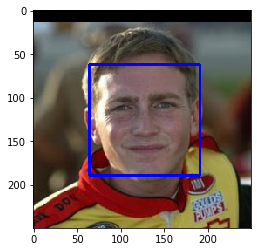

In [4]:
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt                        
%matplotlib inline

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Human Face Detector

We can use this procedure to write a function that returns True if a human face is detected in an image and False otherwise. This function, apply named face_detector, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
def human_detector(img_path):
    """Return True if at least one face is detected in the image"""
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    wrong_faces = 0
    threshold = 30.
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        
        # check if face is smaller than 30% of the image
        # (most wrong detections are caused by this problem)
        img_w, img_h = img.shape[0], img.shape[1]
        if (w * 100 / img_w) < threshold and (h * 100 / img_h) < threshold:
            wrong_faces += 1
            
    prediction = (len(faces) - wrong_faces) > 0
    return prediction


def score_human_detections(images_paths):
    """Return the number of detections in percentage"""
    counter = 0
    for img in tqdm(images_paths):
        if human_detector(img):
            counter += 1
    return counter * 100 / len(images_paths)

In [6]:
# Test the performance of the human_detector function
all_dog_images = np.concatenate([train_files, valid_files, test_files], axis=0)

score1 = score_human_detections(human_files)
score2 = score_human_detections(all_dog_images)

print(f"In all human images, {score1:.4f}% are detected as human images")
print(f"In all dog images, {score2:.4f}% are detected as human images")

100%|██████████| 8351/8351 [06:38<00:00, 20.93it/s]

In all human images, 98.6095% are detected as human images
In all dog images, 3.2691% are detected as human images


## Step 2: Detect Dogs

To detect dogs we will use instead a pre-trained ResNet-50 model along with weights that have been trained on ImageNet dataset.  
Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Write a Dog Detector

The model will return the index of the 1000 labels in the ImageNet dataset.
The categories corresponding to dogs are between 151 and 268 inclusive.

In [8]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True  


def path_to_tensor(img_path):
    """loads RGB image and convert it to 4D tensor with shape (1, 224, 224, 3)"""
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)


def paths_to_tensor(img_paths):
    """Apply the 'path_to_tensor' function to a list of image paths"""
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


def dog_detector(img_path):
    """Returns True if a dog is detected in the image"""
    img = preprocess_input(path_to_tensor(img_path))
    prediction = np.argmax(ResNet50_model.predict(img))
    return 151 <= prediction <= 268


def score_dog_detections(images_paths):
    """Return the number of detections in percentage"""
    counter = 0
    for img in tqdm(images_paths):
        if dog_detector(img):
            counter += 1
    return counter * 100 / len(images_paths)

In [9]:
# Test the performance of the dog_detector function
score1 = score_dog_detections(human_files)
score2 = score_dog_detections(all_dog_images)

print(f"In all human images, {score1:.4f}% are detected as dog images")
print(f"In all dog images, {score2:.4f}% are detected as dog images")

100%|██████████| 8351/8351 [02:57<00:00, 46.93it/s]

In all human images, 1.1184% are detected as dog images
In all dog images, 98.4672% are detected as dog images


## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)
The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02633.jpg" width="200"> | <img src="images/Welsh_springer_spaniel_08222.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03889.jpg" width="200"> | <img src="images/American_water_spaniel_00631.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="200"> | <img src="images/Labrador_retriever_06475.jpg" width="240">
Black Labrador 
<img src="images/Labrador_retriever_06449.jpg" width="220">

A random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Data pre-processing

In [10]:
# pre-process the data for Keras by converting every value in range 0 - 1
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:03<00:00, 229.15it/s]


To help against overfitting we will use label smoothing technique.

In [11]:
def label_smoothing(labels, factor=0.12):
    """This function applies label smoothing"""
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels


train_targets = label_smoothing(train_targets)
valid_targets = label_smoothing(valid_targets)
test_targets = label_smoothing(test_targets)

### Model Architecture

This is a simple model where I have alternated convolutions with 2x2 strides batch normalization layers and Parametric Rectified linear units activation functions. After this feature extraction part, I have used a global average pooling and 2 fully connected layers.
To reduce overfitting I used L2 regularization for the convolution layers and dropout for the fully connected layer.
This model is quite fast to train and provides average performances, making it a good starting point.

In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, BatchNormalization, PReLU, Dropout
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Sequential

In [13]:
model = Sequential()

# block 1
model.add(Conv2D(filters=32, kernel_size=(5,5) , strides=(2, 2),
                 kernel_initializer="he_uniform", bias_initializer="zeros",
                 kernel_regularizer=L1L2(0, 1e-4), padding="SAME", input_shape=(224, 224, 3)))
model.add(BatchNormalization(momentum=0.1))
model.add(PReLU(shared_axes=[1, 2]))

# block 2
model.add(Conv2D(filters=64, kernel_size=(5,5) , strides=(2, 2),
                 kernel_initializer="he_uniform", bias_initializer="zeros",
                 kernel_regularizer=L1L2(0, 1e-4), padding="SAME"))
model.add(BatchNormalization(momentum=0.1))
model.add(PReLU(shared_axes=[1, 2]))

# block 3
model.add(Conv2D(filters=128, kernel_size=(5,5) , strides=(2, 2),
                 kernel_initializer="he_uniform", bias_initializer="zeros",
                 kernel_regularizer=L1L2(0, 1e-4), padding="SAME"))
model.add(BatchNormalization(momentum=0.1))
model.add(PReLU(shared_axes=[1, 2]))

# block 4
model.add(Conv2D(filters=256, kernel_size=(5,5) , strides=(2, 2),
                 kernel_initializer="he_uniform", bias_initializer="zeros",
                 kernel_regularizer=L1L2(0, 1e-4), padding="SAME"))
model.add(BatchNormalization(momentum=0.1))
model.add(PReLU(shared_axes=[1, 2]))

# block 5
model.add(Conv2D(filters=512, kernel_size=(5,5) , strides=(2, 2),
                 kernel_initializer="he_uniform", bias_initializer="zeros",
                 kernel_regularizer=L1L2(0, 1e-4), padding="SAME"))
model.add(BatchNormalization(momentum=0.1))
model.add(PReLU(shared_axes=[1, 2]))
model.add(GlobalAveragePooling2D())

# fully connected block
model.add(Dense(256, kernel_initializer="he_uniform", bias_initializer="zeros"))
model.add(BatchNormalization(momentum=0.1))
model.add(PReLU())
model.add(Dropout(0.2))

# output
model.add(Dense(133, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
p_re_lu (PReLU)              (None, 112, 112, 32)      32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        256       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 56, 56, 64)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       2

### Compile and Train the Model

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True, monitor="val_acc", mode="max")

history= model.fit(train_tensors, train_targets, 
                   validation_data=(valid_tensors, valid_targets),
                   epochs=10, batch_size=32, callbacks=[checkpointer], verbose=0)

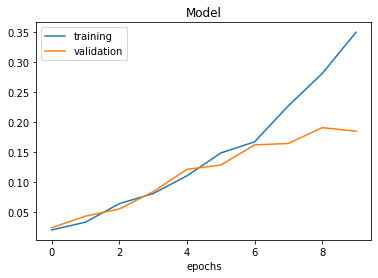

In [16]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.legend(["training", "validation"])
plt.title("Model")
plt.xlabel("epochs")
plt.show()

### Load the Model with the Best Validation Loss

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

In [18]:
score = model.evaluate(test_tensors, test_targets, verbose=0)
print(f'Test accuracy: {score[1]:.4f}')

Test accuracy: 0.2129


The accuracy of the model is very low, let's improve it by using transfert learning.

## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images.
We will use the feature extraction part of Xception trained on imagenet dataset and some fully connected layers with average and max pooling to make the prediction.

### Obtain Bottleneck Features
In the first training part the feature extraction part will not be trained, so we will set the layers as non trainable.

In [19]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image

# define Xception model
xception_model = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in xception_model.layers:
    layer.trainable = False

### Model Architecture

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPool2D, Add


# 1st branch
avg_pool = GlobalAveragePooling2D(name="avg_pool")(xception_model.output)
fc1_1 = Dense(512, name="avg_dense", kernel_initializer="he_uniform", bias_initializer="zeros")(avg_pool)
fc1_1 = BatchNormalization(momentum=0.1, name="avg_batchnorm")(fc1_1)
fc1_1 = PReLU(name="avg_prelu")(fc1_1)

# 2nd branch
max_pool = GlobalMaxPool2D(name="max_pool")(xception_model.output)
fc1_2 = Dense(512, name="max_dense", kernel_initializer="he_uniform", bias_initializer="zeros")(max_pool)
fc1_2 = BatchNormalization(momentum=0.1, name="max_batchnorm")(fc1_2)
fc1_2 = PReLU(name="max_prelu")(fc1_2)

# combining both branches
comb = Add(name="add")([fc1_1, fc1_2])
comb = Dropout(0.3)(comb)
fc2 = Dense(512, name="fc2", kernel_initializer="he_uniform", bias_initializer="zeros")(comb)
fc2 = BatchNormalization(momentum=0.1, name="fc2_batchnorm")(fc2)
fc2 = PReLU(name="fc2_prelu")(fc2)
fc2 = Dropout(0.3)(fc2)

# output
out = Dense(133, activation='softmax')(fc2)

# model
my_xception_model = Model(xception_model.input, out)

### Data augmentation

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen = ImageDataGenerator(width_shift_range=0.3,
                             height_shift_range=0.3,
                             zoom_range=.3,
                             shear_range=0.1,
                             rotation_range=10,
                             horizontal_flip=True,
                             vertical_flip=True)

datagen.fit(train_tensors)

### Compile the Model

In [22]:
from tensorflow.keras.optimizers import Adam

my_xception_model.compile(loss='categorical_crossentropy', 
                          optimizer=Adam(lr=0.001), 
                          metrics=['accuracy'])

### Train the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


callbacks = [
    ModelCheckpoint(filepath='saved_models/Xception_model.weights.best.hdf5', verbose=1, 
                    save_best_only=True, monitor='val_acc'),
    EarlyStopping(monitor='val_acc', patience=20, verbose=1),
    ReduceLROnPlateau(patience=10, monitor="val_acc", verbose=1, min_lr=1e-7, mode="max")
]

# pre-training
my_xception_model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=24),
                                epochs=50, steps_per_epoch=300, callbacks=callbacks, 
                                verbose=0, validation_data=(valid_tensors, valid_targets))

# final training
for layer in my_xception_model.layers:
    layer.trainable = True

my_xception_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-5), metrics=['accuracy'])

history = my_xception_model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=24),
                                          epochs=100, steps_per_epoch=200, callbacks=callbacks, 
                                          verbose=1, validation_data=(valid_tensors, valid_targets))

### View training history

Text(0.5, 0, 'epoch')

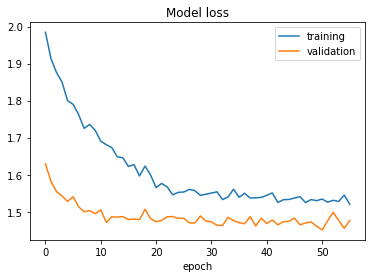

In [24]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["training", "validation"])
plt.title("Model loss")
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

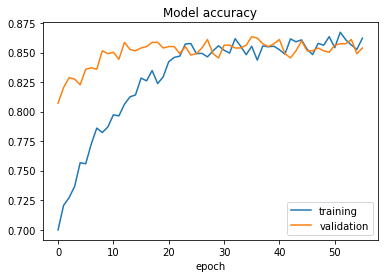

In [25]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.legend(["training", "validation"])
plt.title("Model accuracy")
plt.xlabel("epoch")

### Load the Model with the Best Validation Loss

In [26]:
my_xception_model.load_weights('saved_models/Xception_model.weights.best.hdf5')

### Test the Model

In [27]:
score = my_xception_model.evaluate(test_tensors, test_targets, verbose=0)
print(f'Test accuracy: {score[1]:.4f}')

Test accuracy: 0.8612


### Predict Dog Breed with the Model

In [28]:
# return dog breed from image path
def Xception_predict_breed(img_path):
    image_ = path_to_tensor(img_path) / 255
    predicted_vector = my_xception_model.predict(image_)
    return dog_names[np.argmax(predicted_vector)]

## Step 5: Write the Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [29]:
#check if the provided path exist and has a supported extension
def check_file_path(img_path):
    if not os.path.isfile(img_path):
        return False, "The provided path doesn't exist!"
    extensions = [".jpg", ".jpeg", ".png", ".bmp"]
    for ext in extensions:
        if img_path.endswith(ext):
            return True, ""
    return False, 'The file is not supported, only "jpg", "jpeg", "png" and "bmp" are accepted.'


def show_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()


def dog_breed_prediction(image_path):
    path_is_ok, outputstring = check_file_path(image_path)
    if not path_is_ok:
        print(outputstring, "\n")
        return None
    is_human = human_detector(image_path)
    is_dog = dog_detector(image_path)
    if is_dog:
        print("Hello, dog!")
        breed = Xception_predict_breed(image_path)
        show_image(image_path)
        print("This is a {}!".format(breed))
    elif is_human:
        print("Hello, human!")
        breed = Xception_predict_breed(image_path)
        show_image(image_path)
        print("You look like a ... {}!".format(breed))
    else:
        print("Error, not able to detect humans or dogs in the provided picture!")
        show_image(image_path)

## Step 6: Test the Algorithm

Test your algorithm at least six images on your computer.  Feel free to use any images you like.

Hello, dog!


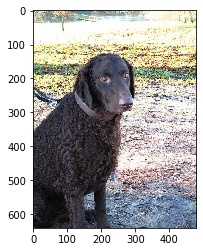

This is a Curly-coated_retriever!
It was a Curly-coated_retriever_03889.jpg


Hello, dog!


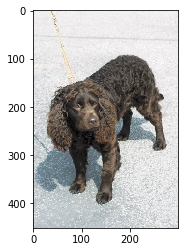

This is a American_water_spaniel!
It was a American_water_spaniel_00631.jpg


Hello, dog!


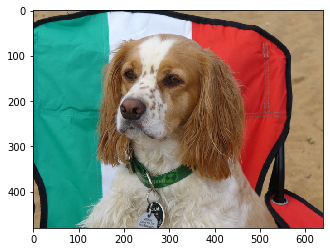

This is a Welsh_springer_spaniel!
It was a Welsh_springer_spaniel_08222.jpg


Hello, dog!


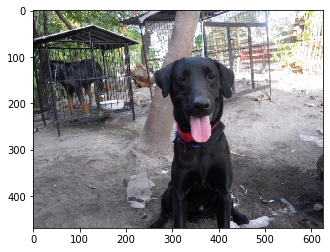

This is a Labrador_retriever!
It was a Labrador_retriever_06449.jpg


Hello, dog!


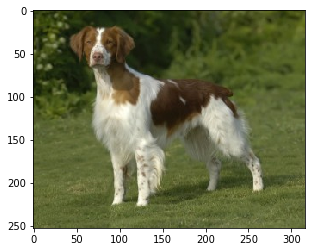

This is a Brittany!
It was a Brittany_02633.jpg


Hello, dog!


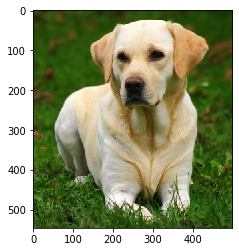

This is a Labrador_retriever!
It was a Labrador_retriever_06457.jpg


Hello, dog!


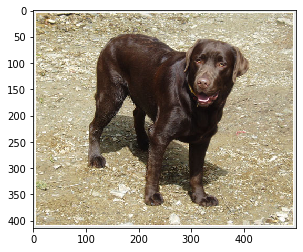

This is a Labrador_retriever!
It was a Labrador_retriever_06475.jpg


Hello, human!


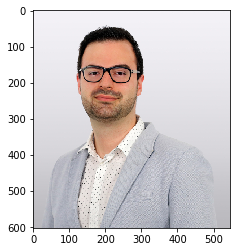

You look like a ... Poodle!
It was a Me.jpg




In [31]:
for img in os.listdir("images"):
    dog_breed_prediction(os.path.join("images", img))
    print("It was a {}\n\n".format(img))